## Carter Kohn Integration Tests ##

In this notebook, I use the Kalman class to simulate some code to ensure that it works as expected.  I try several different scenarios.

In [123]:
import numpy as np
from scipy import stats
from scipy import linalg as scilin
from bayesiankalman import kalmanfilter as kf
from bayesiankalman.kalmanfilter import Kalman
from bayesiankalman import mcmc
import pandas as pd
from tqdm import tqdm
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [124]:
%matplotlib inline

In [125]:
import bayesiankalman

In [173]:
state_dim = 2
data_dim = int(2000)
time_dim = 1000
num_draws = 100

In [174]:
data_innov_var_beta = np.eye(data_dim)
state_innov_var_beta = np.eye(state_dim)
data_innov_var_alpha = 20 + data_dim
state_innov_var_alpha = 20 + state_dim
data_mean_mean = np.zeros(data_dim)
data_mean_var = 2
state_trans_mean = .9 * np.eye(state_dim)
state_trans_var = 2
measurement_loadings_mean = np.eye(data_dim, state_dim)
measurement_loadings_var = 2

In [175]:
data_innov_var = stats.invwishart.rvs(df=data_innov_var_alpha, scale=data_innov_var_beta)

In [176]:
state_trans = mcmc.make_stationary(stats.multivariate_normal.rvs(
    mean=state_trans_mean.ravel(order='F'),cov=state_trans_var).reshape((state_dim, state_dim)))
# state_trans = np.asarray([[.80, -.01,],[1,0]])

In [177]:
# state_innov_var = np.asarray([[1, 0, ], [0,0]])

In [178]:
# measurement_loadings = stats.multivariate_normal.rvs(
#     measurement_loadings_mean.ravel(order='F'), measurement_loadings_var).reshape((data_dim), state_dim)

In [179]:
measurement_loadings = np.ones((data_dim, state_dim))
# measurement_loadings = np.array([1,0]) 

In [180]:
state_innov_var = stats.invwishart.rvs(df=state_innov_var_alpha, scale=state_innov_var_beta)
data_mean = stats.multivariate_normal.rvs(data_mean_mean, data_mean_var)
# data_mean = np.zeros(data_dim)
# state_mean = np.random.standard_normal(state_dim)
state_mean = np.zeros(state_dim)
# state_mean = np.asarray([1,0])

In [181]:
model = kf.simulate_model(data_mean=data_mean, 
                          state_trans=state_trans, 
                          data_loadings=measurement_loadings, 
                          state_innov_var=state_innov_var, 
                          data_innov_var=data_innov_var,
                          time_dim=time_dim, 
                          state_mean=state_mean)

In [182]:
data = model.data
states = model.states.copy()

## Estimate the Model ##

In [183]:
prior = {
        'true_vols': {'innov_var': 
                      {'alpha': state_dim + 4, 'beta': .5 * (state_dim + 4) * np.eye(state_dim)}, 
                  'trans': {'mean': .9 * np.eye(state_dim), 'variance': 10 * np.eye(state_dim)}},
        'real_vols': {'innov_var': 
                      {'alpha': data_dim + 4, 'beta': .5 * (data_dim + 4) * np.eye(data_dim)},
                      'mean': {'mean': np.zeros(data_dim), 'variance': 16 * np.eye(data_dim)}}
        }

In [184]:
data_mean_draws = np.empty((num_draws, data_dim))
data_innov_var_draws = np.empty((num_draws, data_dim, data_dim))
state_draws = np.empty((num_draws, time_dim, state_dim))
state_means_draws = np.empty((num_draws, time_dim, state_dim))
state_vars_draws = np.empty((num_draws, time_dim, state_dim, state_dim))
state_innov_var_draws = np.empty((num_draws, state_dim, state_dim))
state_trans_draws = np.empty((num_draws, state_dim, state_dim))

In [185]:
model.attributes_to_update = ['states']

In [186]:
mcmc.rmse(np.median([model.draw_smoothed_states()[0] for _ in range(1000)], axis=1), states)

1.1351149632800317

In [166]:
# mcmc.rmse(model(model.data, prior['true_vols'], prior['real_vols'])['states'],states)

In [167]:
help(model)

Help on Kalman in module bayesiankalman.kalmanfilter object:

class Kalman(builtins.object)
 |  Implements the Carter-Kohn (1993) multi-move Gibbs smoothing algorithm.
 |  
 |  It updates both the state and the parameters. One can choose to update the data loadings or not.
 |  The 'draw' methods only return draws from the conditional posterior, they do not update the state.
 |  
 |  Derivations of the algorithms used can be seen in BayesianKalman.tex. Throughout the documentation we use T to
 |  refer to the number of periods, K to refer to the number of states, and N to refer to the dimension of the data.
 |  We assume that (K <= N).
 |  
 |  
 |  Attributes
 |  ----------
 |  _data : (T, N) ndarray of floats
 |      This contains the observed data.
 |  _states : (T, K) ndarray of floats
 |      This contains the underlying states, which we estimate.
 |  _state_innov_var : (K, K) ndarray of floats
 |      This is the covariance matrix of the state transition equation.
 |  _data_innov_

In [168]:
for draw_idx in tqdm(range(num_draws)):
    parameters = model(model.data, prior['true_vols'], prior['real_vols'])
    data_mean_draws[draw_idx] = parameters['data_mean']
    data_innov_var_draws[draw_idx] = parameters['data_innov_var']
    state_draws[draw_idx] = parameters['states']
    state_means_draws[draw_idx] = parameters['smoothed_means']
    state_vars_draws[draw_idx] = parameters['smoothed_vars']
    state_innov_var_draws[draw_idx] = parameters['state_innov_var']
    state_trans_draws[draw_idx] = parameters['state_trans']

100%|██████████| 100/100 [00:00<00:00, 592.42it/s]


## Compare the Simulation Results ##

In [172]:
mcmc.rmse(model(model.data, prior['true_vols'], prior['real_vols'])['states'], states) 

0.0

In [170]:
percentiles = (1, 5, 50, 95, 99)

In [171]:
state_quantiles = np.percentile(state_draws, percentiles, axis=0)

In [45]:
mcmc.rmse(np.percentile(state_draws, 50, axis=0), states)

0.0

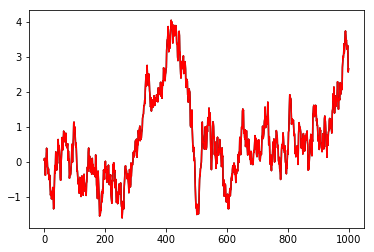

In [38]:
state_comparison_fig, state_comparison_ax = plt.subplots(1,1)
mcmc.fan_plot(state_comparison_ax, pd.DataFrame(state_draws[:,:,1].T), percentiles, c='black')
state_comparison_ax.plot(states[:,1], c='red')
#state_comparison_ax.plot(data, 'blue')
# state_comparison_ax.set_xlim([0,100])
# state_comparison_ax.set_ylim([-5,1])

In [39]:
data_mean_quantiles = np.percentile(data_mean_draws, percentiles, axis=0)

print('The data mean quantiles are ' + str(data_mean_quantiles[:,0]))
print('The data mean is ' + str(data_mean))

root_mean_square_error_data_mean = mcmc.rmse(data_mean_quantiles[1], data_mean)
print('The root mean square error is ' + str(root_mean_square_error_data_mean / data_mean.size))

The data mean quantiles are [-0.14237003 -0.14237003 -0.14237003 -0.14237003 -0.14237003]
The data mean is [-0.14237003  0.62269573  1.38056225 -1.21640113 -1.33255215  0.07530202
 -0.78728528  1.71555229  0.14127818  1.24882904  1.29514119 -0.22254153
  0.8867556  -0.20518267  0.85253858  0.52885521  1.08325362  1.7101692
 -0.35921788 -0.58156032 -1.05726339  0.62766725 -0.47422695 -0.79468459
 -0.41476735 -0.7099358  -0.64461661  0.13651394 -3.51749519  1.68370664
 -0.34024605  2.60370108 -2.94779915 -0.04868542 -1.27484255  0.36006354
  0.68538667 -1.07735867  1.10335539  1.83018194 -0.25857604 -1.9093182
 -1.25706292 -2.07398386 -1.77791428  0.82441385 -2.80344091 -1.87583286
  1.84707628  1.73109442  2.20791444  0.68070095 -0.55889022  2.25554431
 -0.35131319 -2.09651797 -0.36243507  0.69485355  0.62130995 -0.98332372
 -0.53692123 -0.42284025  3.41233595 -0.63501542 -1.94090521 -1.54171135
  0.46430806 -0.91278795 -0.42524406 -1.43676668 -1.39375842  0.0445763
 -1.42809524 -0.7811

In [40]:
data_innov_var_quantiles = np.percentile(data_innov_var_draws, percentiles, axis=0)

print('The data innovation variance median is: \n' + str(data_innov_var_quantiles[1]))
print('\nThe data innovation variance is: \n' + str(data_innov_var))

print('\nThe root mean square error is ' + str(mcmc.rmse(data_innov_var_quantiles[1], data_innov_var)))

The data innovation variance median is: 
[[ 0.03906943 -0.02143347  0.00884621 ...,  0.00611407  0.01728074
   0.02362485]
 [-0.02143347  0.13677233  0.00742027 ...,  0.01338191 -0.03209003
  -0.03986627]
 [ 0.00884621  0.00742027  0.03819467 ...,  0.00754137  0.01009673
   0.00226451]
 ..., 
 [ 0.00611407  0.01338191  0.00754137 ...,  0.04523431  0.0023211
   0.01268266]
 [ 0.01728074 -0.03209003  0.01009673 ...,  0.0023211   0.05023249
   0.01959083]
 [ 0.02362485 -0.03986627  0.00226451 ...,  0.01268266  0.01959083
   0.08151112]]

The data innovation variance is: 
[[ 0.03906943 -0.02143347  0.00884621 ...,  0.00611407  0.01728074
   0.02362485]
 [-0.02143347  0.13677233  0.00742027 ...,  0.01338191 -0.03209003
  -0.03986627]
 [ 0.00884621  0.00742027  0.03819467 ...,  0.00754137  0.01009673
   0.00226451]
 ..., 
 [ 0.00611407  0.01338191  0.00754137 ...,  0.04523431  0.0023211
   0.01268266]
 [ 0.01728074 -0.03209003  0.01009673 ...,  0.0023211   0.05023249
   0.01959083]
 [ 0.0236

In [41]:
state_innov_var_quantiles = np.percentile(state_innov_var_draws, percentiles, axis=0)

print('The state innovation variance quantiles are: \n' + str(state_innov_var_quantiles))
print('\nThe state innovation variance is: \n' + str(state_innov_var))

print('\nThe root mean square error is: \n' + str(mcmc.rmse(state_innov_var_quantiles[1], state_innov_var)))

The state innovation variance quantiles are: 
[[[ 0.1015132  -0.00466843]
  [-0.00466843  0.04774388]]

 [[ 0.1015132  -0.00466843]
  [-0.00466843  0.04774388]]

 [[ 0.1015132  -0.00466843]
  [-0.00466843  0.04774388]]

 [[ 0.1015132  -0.00466843]
  [-0.00466843  0.04774388]]

 [[ 0.1015132  -0.00466843]
  [-0.00466843  0.04774388]]]

The state innovation variance is: 
[[ 0.1015132  -0.00466843]
 [-0.00466843  0.04774388]]

The root mean square error is: 
0.0


In [42]:
np.percentile(state_trans_draws[:,0,0] - state_trans_draws[:,0,1], percentiles, axis=0)

array([-0.99009901, -0.99009901, -0.99009901, -0.99009901, -0.99009901])

In [43]:
state_trans_quantiles = np.percentile(state_trans_draws, percentiles, axis=0)

print('The state transition matrix quantiles are: \n' + str(state_trans_quantiles))
print('\nThe state transition matrix is: \n' + str(state_trans))

print('\nThe root mean square error is: ' + str(mcmc.rmse(state_trans_quantiles[1], state_trans)))

The state transition matrix quantiles are: 
[[[ -9.90099010e-01  -2.77837044e-17]
  [  4.57692999e-17   9.90099010e-01]]

 [[ -9.90099010e-01  -2.77837044e-17]
  [  4.57692999e-17   9.90099010e-01]]

 [[ -9.90099010e-01  -2.77837044e-17]
  [  4.57692999e-17   9.90099010e-01]]

 [[ -9.90099010e-01  -2.77837044e-17]
  [  4.57692999e-17   9.90099010e-01]]

 [[ -9.90099010e-01  -2.77837044e-17]
  [  4.57692999e-17   9.90099010e-01]]]

The state transition matrix is: 
[[ -9.90099010e-01  -2.77837044e-17]
 [  4.57692999e-17   9.90099010e-01]]

The root mean square error is: 0.0
